## Direct Marketing Optimization

This case study explores optimizing direct marketing campaigns to maximize revenue through data-driven customer targeting. I developed propensity models to predict purchase likelihood for three financial products: Consumer Loans (CL), Credit Cards (CC), and Mutual Funds (MF). The goal is to identify which customers are most likely to purchase specific products, enabling more effective allocation of marketing resources.

**Part 1: Model Development and Evaluation**
I developed and compared three LightGBM binary classification models:
1. LGBM with manually tuned parameters with scaled class weights
2. LGBM with manually tuned parameters with SMOTE resampling for class balancing
3. LGBM tuned with Optuna for automated hyperparameter optimization, incorporating:
   - Stratified 5-fold cross-validation for robust performance assessment
   - Class weight scaling to handle imbalanced target distributions

The models were optimized using a composite metric combining PR-AUC and Brier loss:

$score = pr\_auc - (brier\_loss \times 0.1)$

I used brier loss as a calibration metric since the propensity value is calculated from the prediction probabilities. Brier loss evaluates how well-calibrated probabilities are, ensuring expected revenue estimates are meaningful. The second component, PR-AUC (Precision-Recall Area Under Curve), was chosen because it excels at ranking positive cases (successful sales) in imbalanced datasets like ours where actual sales are the minority class. This makes PR-AUC particularly effective at identifying likely buyers.

For each product, the model with the highest composite score was selected.

**Part 2: Revenue Maximization Strategy**
Given operational constraints of contacting only 15% of clients with a single product offer each, I evaluated two targeting approaches:
1. Pure revenue maximization: Selecting top 15% of clients based solely on expected revenue
2. Balanced optimization: First identifying highest propensity matches per product, then ranking by revenue potential

Both strategies proved effective, with the pure revenue approach generating slightly higher expected returns (S$1,359 vs S$1,330). While the balanced approach offered better product diversity by including MF recommendations, the pure revenue strategy better aligns with our primary objective of maximizing returns. Therefore, our final recommendation achieves an expected revenue of S$1,359. However, it's worth noting that in real-world applications, the balanced approach may be preferable as it supports broader product promotion while maintaining strong revenue potential.

**Answers to Case Study Questions** <br>
The case study included several key questions about model performance, revenue optimization strategies, and business recommendations. Detailed answers and analysis for each question can be found at the end of this notebook.

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Utilities
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Hyperparameter Tuning
import optuna

# Models
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

# Custom Modules
from lib.train_functions import train_classifier, evaluate_model_performance
from lib.optim_utils import save_params, load_params,  cross_validation, get_client_characteristics
from lib.optim_functions import objective_lgbm

# Toggle off when not turning hyperparams (to not overwrite my existing parameter set)
TUNING_HYPERPARAM = True

In [2]:
X_base = pd.read_csv('./data/X.csv', index_col=0)
y_base = pd.read_csv('./data/y.csv', index_col=0)
df_sales_revenues = pd.read_excel('./data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Sales_Revenues')

### Data Preprocessing

#### Data Scaling / Normalization

In [3]:
# LGBM is a tree-based model so I don't need to scale the data

# # Initialize and fit StandardScaler on X_base (excluding 'Client' column)
# scaler = StandardScaler()
# scalable_columns = X_base.columns[1:]
# X_base[scalable_columns] = scaler.fit_transform(X_base[scalable_columns])

#### Data Wrangling

In [4]:
# Extract clients with and without target labels (only 60% of dataset has labels)
sales_clients = set(df_sales_revenues.Client)
y = y_base[y_base.Client.isin(sales_clients)].reset_index(drop=True)  # 60% of data with target labels
y_hidden = y_base[~y_base.Client.isin(sales_clients)].reset_index(drop=True)  # 40% of data without target labels

X = X_base[X_base.Client.isin(sales_clients)].reset_index(drop=True)
X_hidden = X_base[~X_base.Client.isin(sales_clients)].reset_index(drop=True)

X_clients = X.Client
X_hidden_clients = X_hidden.Client

# Drop Client column
X = X.drop(columns=['Client'])
X_hidden = X_hidden.drop(columns=['Client'])

print(f'Shape of y: {y.shape}')
print(f'Shape of y_hidden: {y_hidden.shape}')
print(f'Shape of X: {X.shape}')
print(f'Shape of X_hidden: {X_hidden.shape}')


Shape of y: (969, 7)
Shape of y_hidden: (646, 7)
Shape of X: (969, 28)
Shape of X_hidden: (646, 28)


In [5]:
# Split the target labels into separate series for each product
y_MF = y.Sale_MF
y_CC = y.Sale_CC
y_CL = y.Sale_CL
y_hidden_MF = y_hidden.Sale_MF
y_hidden_CC = y_hidden.Sale_CC
y_hidden_CL = y_hidden.Sale_CL

print(f'Shape of y_MF: {y_MF.shape}')
print(f'Shape of y_CC: {y_CC.shape}')
print(f'Shape of y_CL: {y_CL.shape}')
print(f'Shape of y_hidden_MF: {y_hidden_MF.shape}')
print(f'Shape of y_hidden_CC: {y_hidden_CC.shape}')
print(f'Shape of y_hidden_CL: {y_hidden_CL.shape}')


Shape of y_MF: (969,)
Shape of y_CC: (969,)
Shape of y_CL: (969,)
Shape of y_hidden_MF: (646,)
Shape of y_hidden_CC: (646,)
Shape of y_hidden_CL: (646,)


In [6]:
# Train-Test Split for each labelled product
X_train, X_test, y_MF_train, y_MF_test = train_test_split(X, y_MF, test_size=0.2, random_state=42)
X_train, X_test, y_CC_train, y_CC_test = train_test_split(X, y_CC, test_size=0.2, random_state=42)
X_train, X_test, y_CL_train, y_CL_test = train_test_split(X, y_CL, test_size=0.2, random_state=42)

### Model Training

For each product, train a **binary classification model**.

I'll begin with establishing a baseline model first.

#### Base LGBM via manual tuning

In [7]:
# I'll collect my results here
models = {}
model_params = {}
roc_auc_scores = {}
propensity_scores = {}
propensity_scores_hidden = {}

target_product_data = [('MF', X_train, X_test, y_MF_train, y_MF_test), ('CC', X_train, X_test, y_CC_train, y_CC_test), ('CL', X_train, X_test, y_CL_train, y_CL_test)]

In [8]:
for (tag, X_train, X_test, y_train, y_test) in target_product_data:

    # 1. Set training parameters
    model_params[f'base_{tag}'] = {'boosting_type': 'gbdt', 
                                    'objective': 'binary',
                                    'n_estimators': 200,
                                    'learning_rate': 0.05,
                                    'max_depth': 7,
                                    'colsample_bytree': 0.8,
                                    'subsample': 0.8,
                                    'random_state': 42}

    # 2. Train model, record scores
    clf = LGBMClassifier(verbose=-1, is_unbalance=True, **model_params[f'base_{tag}'])
    models[f'base_{tag}'] = train_classifier(clf, X_train, y_train)

    # 3. Evaluate model performance on test set
    roc_auc_scores[f'base_{tag}'] = evaluate_model_performance(models[f'base_{tag}'], X_test, y_test)

    # 4. Calcualte propensity scores for the entire dataset (labelled 60% and hidden 40%)
    propensity_scores[f'base_{tag}'] = models[f'base_{tag}'].predict_proba(X)[:, 1]
    propensity_scores_hidden[f'base_{tag}'] = models[f'base_{tag}'].predict_proba(X_hidden)[:, 1]

    del clf


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[123  31]
 [ 32   8]]
Precision Score: 0.2051
Recall Score: 0.2000
F1 Score: 0.2025
PR-AUC Score: 0.2532
ROC-AUC Score: 0.5390
Brier Score: 0.2236
PR-AUC-Brier Score: 0.2308


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[122  23]
 [ 33  16]]
Precision Score: 0.4103
Recall Score: 0.3265
F1 Score: 0.3636
PR-AUC Score: 0.4094
ROC-AUC Score: 0.6272
Brier Score: 0.2009
PR-AUC-Brier Score: 0.3893


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[107  33]
 [ 31  23]]
Precision Score: 0.4107
Recall Score: 0.4259
F1 Score: 0.4182
PR-AUC Score: 0.4131
ROC-AUC Score: 0.6537
Brier Score: 0.2127
PR-AUC-Brier Score: 0.3918




#### LGBM with SMOTE via manual tuning

In [9]:
for (tag, X_train, X_test, y_train, y_test) in target_product_data:

    # 1. Set training parameters
    model_params[f'base_smote_{tag}'] = {'boosting_type': 'gbdt', 
                                        'objective': 'binary',
                                        'n_estimators': 200,
                                        'learning_rate': 0.05,
                                        'max_depth': 7,
                                        'colsample_bytree': 0.8,
                                        'subsample': 0.8,
                                        'random_state': 42}

    smote_params = {'sampling_strategy': 'minority',
                    'random_state': 42,
                    'k_neighbors': 5,
                    'n_jobs': -1}

    # 2. Train model, record scores
    clf = LGBMClassifier(verbose=-1, **model_params[f'base_smote_{tag}'])
    models[f'base_smote_{tag}'] = train_classifier(clf, X_train, y_train)

    # 3. Evaluate model performance on test set
    roc_auc_scores[f'base_smote_{tag}'] = evaluate_model_performance(models[f'base_smote_{tag}'], X_test, y_test)

    # 4. Calcualte propensity scores for the entire dataset (labelled 60% and hidden 40%)
    propensity_scores[f'base_smote_{tag}'] = models[f'base_smote_{tag}'].predict_proba(X)[:, 1]
    propensity_scores_hidden[f'base_smote_{tag}'] = models[f'base_smote_{tag}'].predict_proba(X_hidden)[:, 1]

    del clf


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[140  14]
 [ 37   3]]
Precision Score: 0.1765
Recall Score: 0.0750
F1 Score: 0.1053
PR-AUC Score: 0.2405
ROC-AUC Score: 0.5231
Brier Score: 0.2005
PR-AUC-Brier Score: 0.2204


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[132  13]
 [ 42   7]]
Precision Score: 0.3500
Recall Score: 0.1429
F1 Score: 0.2029
PR-AUC Score: 0.4147
ROC-AUC Score: 0.6380
Brier Score: 0.1921
PR-AUC-Brier Score: 0.3955


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[117  23]
 [ 40  14]]
Precision Score: 0.3784
Recall Score: 0.2593
F1 Score: 0.3077
PR-AUC Score: 0.4320
ROC-AUC Score: 0.6462
Brier Score: 0.2054
PR-AUC-Brier Score: 0.4115




### Hyperparameter Tuning with Optuna

##### Base LGBM via Optuna

In [10]:
if TUNING_HYPERPARAM:

    n_trials = 80
    timeout = 3600
    
    for (tag, X_train, X_test, y_train, y_test) in target_product_data:

        # 1. Use optuna to find the best hyperparameters for each product
        study = optuna.create_study(study_name=f'optuna_lgbm_{tag}', 
                                    direction='maximize')
        
        study.optimize(lambda trial: objective_lgbm(trial, X_train, y_train),
                       n_trials=n_trials,
                       timeout=timeout)

        print(f"Best trial for optuna_lgbm_{tag}:")
        print(f" Value: {study.best_value:.4f}")
        print("  Params: ")

        # save best params
        for key, value in study.best_params.items():
            print(f"    {key}: {value}")

        model_params[f'optuna_lgbm_{tag}'] = study.best_params
        save_params(model_params[f'optuna_lgbm_{tag}'], f'optuna_lgbm_{tag}')

        # 2. Train the model with the best hyperparameters, record scores
        clf = LGBMClassifier(**study.best_params,
                             n_jobs=-1,
                             verbosity=-1,
                             boosting_type="gbdt",
                             objective='binary',
                             random_state=42,
                             is_unbalance=True)
            
        models[f'optuna_lgbm_{tag}'] = train_classifier(clf, X_train, y_train)

        # 3. Evaluate model performance on test set 
        roc_auc_scores[f'optuna_lgbm_{tag}'] = evaluate_model_performance(models[f'optuna_lgbm_{tag}'], X_test, y_test)

        # 4. Calculate propensity scores for the entire dataset (labelled 60% and hidden 40%)
        propensity_scores[f'optuna_lgbm_{tag}'] = models[f'optuna_lgbm_{tag}'].predict_proba(X)[:, 1]
        propensity_scores_hidden[f'optuna_lgbm_{tag}'] = models[f'optuna_lgbm_{tag}'].predict_proba(X_hidden)[:, 1]

        del study, clf



[I 2025-03-17 05:24:13,636] A new study created in memory with name: optuna_lgbm_MF
[I 2025-03-17 05:24:19,491] Trial 0 finished with value: 0.28160068501730534 and parameters: {'num_leaves': 487, 'learning_rate': 0.017951945018624706, 'n_estimators': 1409, 'min_child_samples': 23, 'reg_alpha': 0.06462137684086905, 'reg_lambda': 0.6756998024606006, 'colsample_bytree': 0.7135932992143885, 'subsample': 0.8747693675981459, 'max_depth': 10, 'feature_fraction': 0.7450446395572736, 'bagging_fraction': 0.7240357546584315, 'bagging_freq': 7}. Best is trial 0 with value: 0.28160068501730534.
[I 2025-03-17 05:24:21,837] Trial 1 finished with value: 0.2967539019526044 and parameters: {'num_leaves': 493, 'learning_rate': 0.005899976777513641, 'n_estimators': 1595, 'min_child_samples': 80, 'reg_alpha': 0.011823507437724956, 'reg_lambda': 0.0029953659028657117, 'colsample_bytree': 0.6399747098997703, 'subsample': 0.7540045045900364, 'max_depth': 3, 'feature_fraction': 0.5589033579906302, 'bagging_fr

Best trial for optuna_lgbm_MF:
 Value: 0.3109
  Params: 
    num_leaves: 416
    learning_rate: 0.013939153200490238
    n_estimators: 396
    min_child_samples: 19
    reg_alpha: 0.0005013108163175617
    reg_lambda: 0.00040190808221677996
    colsample_bytree: 0.7431708638400324
    subsample: 0.8657039284276586
    max_depth: 3
    feature_fraction: 0.6562687273279283
    bagging_fraction: 0.6340971975133446
    bagging_freq: 3
Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[105  49]
 [ 25  15]]
Precision Score: 0.2344
Recall Score: 0.3750
F1 Score: 0.2885
PR-AUC Score: 0.2729
ROC-AUC Score: 0.5089
Brier Score: 0.2304
PR-AUC-Brier Score: 0.2498




[I 2025-03-17 05:26:45,339] Trial 0 finished with value: 0.2687878310520674 and parameters: {'num_leaves': 350, 'learning_rate': 0.1384582103190262, 'n_estimators': 1910, 'min_child_samples': 99, 'reg_alpha': 0.5107931089211375, 'reg_lambda': 0.00010833314243324426, 'colsample_bytree': 0.7410677495214968, 'subsample': 0.9735127614674648, 'max_depth': 10, 'feature_fraction': 0.6015166493762293, 'bagging_fraction': 0.891030317968887, 'bagging_freq': 2}. Best is trial 0 with value: 0.2687878310520674.
[I 2025-03-17 05:26:47,588] Trial 1 finished with value: 0.33555373706592645 and parameters: {'num_leaves': 43, 'learning_rate': 0.07287798320156627, 'n_estimators': 881, 'min_child_samples': 31, 'reg_alpha': 0.0005337973968694704, 'reg_lambda': 0.06821334443114734, 'colsample_bytree': 0.9620446023715542, 'subsample': 0.7373488273089159, 'max_depth': -1, 'feature_fraction': 0.5314869514373441, 'bagging_fraction': 0.7436114631039389, 'bagging_freq': 5}. Best is trial 1 with value: 0.335553737

Best trial for optuna_lgbm_CC:
 Value: 0.3729
  Params: 
    num_leaves: 451
    learning_rate: 0.006672779862537888
    n_estimators: 1625
    min_child_samples: 10
    reg_alpha: 0.024820660711765034
    reg_lambda: 0.09022870971284112
    colsample_bytree: 0.6982888846598563
    subsample: 0.5987861814347303
    max_depth: 3
    feature_fraction: 0.9174153363570763
    bagging_fraction: 0.8712818587586867
    bagging_freq: 1


[I 2025-03-17 05:31:15,587] A new study created in memory with name: optuna_lgbm_CL


Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[113  32]
 [ 30  19]]
Precision Score: 0.3725
Recall Score: 0.3878
F1 Score: 0.3800
PR-AUC Score: 0.3768
ROC-AUC Score: 0.5751
Brier Score: 0.2148
PR-AUC-Brier Score: 0.3554




[I 2025-03-17 05:31:17,924] Trial 0 finished with value: 0.44608299349417535 and parameters: {'num_leaves': 385, 'learning_rate': 0.0409585607364361, 'n_estimators': 1057, 'min_child_samples': 43, 'reg_alpha': 0.5245671538509512, 'reg_lambda': 0.7424120842831615, 'colsample_bytree': 0.5334087441109385, 'subsample': 0.891063010563309, 'max_depth': -1, 'feature_fraction': 0.9325597241187975, 'bagging_fraction': 0.7096584516572855, 'bagging_freq': 3}. Best is trial 0 with value: 0.44608299349417535.
[I 2025-03-17 05:31:19,717] Trial 1 finished with value: 0.44562731295447106 and parameters: {'num_leaves': 201, 'learning_rate': 0.051747275180122655, 'n_estimators': 1112, 'min_child_samples': 90, 'reg_alpha': 0.023913541258929413, 'reg_lambda': 0.17953038588009987, 'colsample_bytree': 0.7614178096701518, 'subsample': 0.7072390397334012, 'max_depth': -1, 'feature_fraction': 0.9266201890060958, 'bagging_fraction': 0.75372930181971, 'bagging_freq': 6}. Best is trial 0 with value: 0.44608299349

Best trial for optuna_lgbm_CL:
 Value: 0.4977
  Params: 
    num_leaves: 270
    learning_rate: 0.009953913584639366
    n_estimators: 472
    min_child_samples: 80
    reg_alpha: 0.0008385942683193402
    reg_lambda: 0.2280016975075822
    colsample_bytree: 0.5439066343373379
    subsample: 0.690464330621352
    max_depth: 3
    feature_fraction: 0.8824664555958993
    bagging_fraction: 0.7249244490538288
    bagging_freq: 3
Model Performance on Test Set:
-------------------------
Confusion Matrix:
[[100  40]
 [ 22  32]]
Precision Score: 0.4444
Recall Score: 0.5926
F1 Score: 0.5079
PR-AUC Score: 0.4616
ROC-AUC Score: 0.6870
Brier Score: 0.2184
PR-AUC-Brier Score: 0.4398




#### Benchmark Results

In [11]:
# Display Benchmark Results
model_types = ['base', 'base_smote', 'optuna_lgbm']
products = ['MF', 'CC', 'CL']

reshaped_scores = {model: [] for model in model_types}

for model in model_types:
    for product in products:
        key = f'{model}_{product}'
        score = roc_auc_scores.get(key, None)
        reshaped_scores[model].append(score)

# wide format
roc_auc_df = pd.DataFrame(reshaped_scores, index=products)
roc_auc_df.columns.name = 'Model Type'
roc_auc_df.index.name = 'Product'

print("ROC-AUC Scores for baseline Models:")
display(roc_auc_df)

ROC-AUC Scores for baseline Models:


Model Type,base,base_smote,optuna_lgbm
Product,,,
MF,0.230830,0.220438,0.249838
CC,0.389257,0.395533,0.355356
CL,0.391780,0.411490,0.439773


In [12]:
# Select best performing models per product for revenue optimization step
final_models = ['optuna_lgbm_MF', 'base_smote_CC', 'optuna_lgbm_CL']
product_tags = ['MF', 'CC', 'CL']

### Revenue Optimization

As mentioned in the EDA notebook:

Given the dataset characteristics (high sparsity, skewed distributions, and limited revenue data), I believe a reliable yet simple approach is to use an estimated average revenue per sale for each of the 3 products:

Expected revenue = $P_{i,j} \times$ Avg Revenue Per Sale for Product $j$

where:
- $P_{i,j}$ = propensity score for product $j$
- Avg Revenue Per Sale is computed from nonzero revenue values in y.csv

#### Calculate Estimated Revenue per Client per Product

In [13]:
# Calculate and compile propensity scores P_(i,j)
propensity_scores_df = pd.DataFrame(propensity_scores)
propensity_scores_df.insert(0, 'Client', X_clients)
propensity_scores_hidden_df = pd.DataFrame(propensity_scores_hidden)
propensity_scores_hidden_df.insert(0, 'Client', X_hidden_clients)

propensity_scores_all = pd.concat([propensity_scores_df, propensity_scores_hidden_df]).sort_values(by='Client').reset_index(drop=True)


In [14]:
print("Propensity Scores for all clients across selected models:")
propensity_scores_selected = propensity_scores_all[['Client'] + final_models]
propensity_scores_selected

Propensity Scores for all clients across selected models:


,Client,optuna_lgbm_MF,base_smote_CC,optuna_lgbm_CL
0,1,0.645623,0.026400,0.370219
1,2,0.313952,0.054330,0.514453
2,3,0.292764,0.025408,0.581346
3,4,0.178007,0.092217,0.780665
4,5,0.462229,0.135671,0.581455
...,...,...,...,...
1610,1611,0.390175,0.086877,0.657361
1611,1612,0.322363,0.038796,0.289037
1612,1613,0.518598,0.301380,0.381700
1613,1614,0.430535,0.119653,0.469464


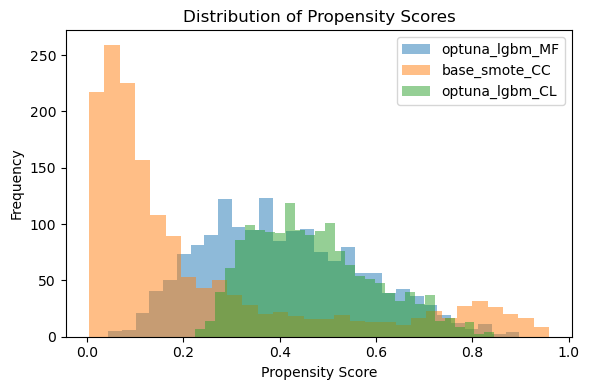

In [94]:
# Let's plot the distribution of propensity scores across products to see how our models assigned the propensity scores
plt.figure(figsize=(6,4))

# Plot histograms for each product type
for col in propensity_scores_selected.columns[1:4]:  # Skip Client column
    plt.hist(propensity_scores_selected[col], 
            alpha=0.5, 
            bins=30,
            label=col)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Compute average revenue per sale
avg_revenue_per_sale = {
    "Sale_MF": y["Revenue_MF"][y["Revenue_MF"] > 0].mean(),
    "Sale_CC": y["Revenue_CC"][y["Revenue_CC"] > 0].mean(), 
    "Sale_CL": y["Revenue_CL"][y["Revenue_CL"] > 0].mean()
}

avg_revenue_per_sale

{'Sale_MF': 9.66497409326425,
 'Sale_CC': 10.862516233766236,
 'Sale_CL': 12.043066502463045}

In [17]:
# Calculate expected revenue across models in benchmark_models
revenue_multipliers = {}

# Map average revenue per sale to corresponding columns in propensity_scores_df
for tag in product_tags:
    revenue = avg_revenue_per_sale[f'Sale_{tag}']
    matching_cols = [col for col in propensity_scores_selected.columns if tag in col]

    for col in matching_cols:
        revenue_multipliers[col] = revenue

# propensity x average revenue per sale
expected_revenue = propensity_scores_selected.copy()
expected_revenue.iloc[:, 1:] = propensity_scores_selected.iloc[:, 1:].mul(revenue_multipliers)

expected_revenue

,Client,optuna_lgbm_MF,base_smote_CC,optuna_lgbm_CL
0,1,6.239931,0.286771,4.458576
1,2,3.034342,0.590165,6.195587
2,3,2.829552,0.275994,7.001190
3,4,1.720433,1.001705,9.401604
4,5,4.467435,1.473725,7.002500
...,...,...,...,...
1610,1611,3.771028,0.943699,7.916645
1611,1612,3.115625,0.421427,3.480892
1612,1613,5.012238,3.273740,4.596843
1613,1614,4.161108,1.299735,5.653781


#### Selecting our Top 15%

The goal of this analysis is to identify a Target Client list containing the top 15% of clients that the bank should prioritize for outreach.

We can generate this list using two different approaches:

1. Select clients based on highest **Expected Revenue**
   - This approach prioritizes clients with highest potential revenue (Propensity × Average Sale Price)
   - May identify fewer but higher-value opportunities
   - Higher risk but potentially higher reward since this approach may trade-off propensity over higher expected revenue outcomes 

2. Select clients based on highest **Propensity Scores**
   - This approach prioritizes clients most likely to purchase, regardless of purchase price
   - Provides more certainty that selected clients will convert
   - Lower risk approach since we focus on likelihood of success

As a Data Scientist, aligning the selection approach with business objectives is crucial.

##### Top 15% by expected revenue
For instance, let's say after discussion with stakeholders, we decided to proceed with Option 1 (Expected Revenue) to maximize potential revenue, accepting the associated higher risk profile.

In [18]:
top_15_len = int(len(X) * 0.15)
top_15_len

145

In [19]:
top_15_pct_by_revenue = {}
total_expected_revenue = {}

# For each client, identify the best offer by estimate revenue (propensity x price) per product
expected_revenue['best_offer'] = expected_revenue.loc[:, final_models].idxmax(axis=1)
expected_revenue['expected_revenue'] = expected_revenue.loc[:, final_models].max(axis=1)

expected_revenue

,Client,optuna_lgbm_MF,base_smote_CC,optuna_lgbm_CL,best_offer,expected_revenue
0,1,6.239931,0.286771,4.458576,optuna_lgbm_MF,6.239931
1,2,3.034342,0.590165,6.195587,optuna_lgbm_CL,6.195587
2,3,2.829552,0.275994,7.001190,optuna_lgbm_CL,7.001190
3,4,1.720433,1.001705,9.401604,optuna_lgbm_CL,9.401604
4,5,4.467435,1.473725,7.002500,optuna_lgbm_CL,7.002500
...,...,...,...,...,...,...
1610,1611,3.771028,0.943699,7.916645,optuna_lgbm_CL,7.916645
1611,1612,3.115625,0.421427,3.480892,optuna_lgbm_CL,3.480892
1612,1613,5.012238,3.273740,4.596843,optuna_lgbm_MF,5.012238
1613,1614,4.161108,1.299735,5.653781,optuna_lgbm_CL,5.653781


In [20]:
# Find the top 15% of clients based on max expected revenue per client
top_15_pct_by_revenue = expected_revenue.sort_values(by="expected_revenue", ascending=False) \
                                        .head(top_15_len) \
                                        .loc[:, ["Client", "best_offer", "expected_revenue"]] \
                                        .reset_index(drop=True)

top_15_pct_by_revenue

,Client,best_offer,expected_revenue
0,1367,base_smote_CC,10.417335
1,721,base_smote_CC,10.395843
2,478,base_smote_CC,10.335526
3,1170,base_smote_CC,10.285756
4,520,base_smote_CC,10.270271
...,...,...,...
140,562,optuna_lgbm_CL,8.786292
141,395,base_smote_CC,8.779584
142,1456,base_smote_CC,8.768839
143,658,base_smote_CC,8.766224


Total expected revenue:

In [21]:
print(f"Total expected revenue from top 15% of clients: ${top_15_pct_by_revenue.expected_revenue.sum():,.2f}")

Total expected revenue from top 15% of clients: $1,359.83


How are the product offers distributed across different models in our benchmark?

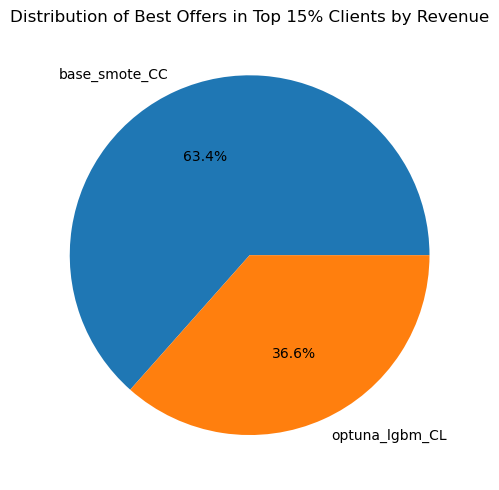

In [22]:
# Plot value counts on a pie chart
plt.figure(figsize=(5, 5))
offer_counts = top_15_pct_by_revenue['best_offer'].value_counts()
plt.pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Best Offers in Top 15% Clients by Revenue')
plt.tight_layout()
plt.show()

##### Top 15% by Revenue & Propensity

Let's explore an alternative approach where we prioritize customer conversion likelihood first, and then consider revenue potential. This shift in strategy could be valuable if stakeholders want to focus on building a broader customer base before maximizing revenue per sale.

In [23]:
top_15_pct_by_prop = {}
total_expected_prop = {}

# For each client, identify the best offer by propensity
propensity_scores_selected['best_offer'] = propensity_scores_selected.loc[:, final_models].idxmax(axis=1)
propensity_scores_selected['max_prop'] = propensity_scores_selected.loc[:, final_models].max(axis=1)

# sample
propensity_scores_selected

,Client,optuna_lgbm_MF,base_smote_CC,optuna_lgbm_CL,best_offer,max_prop
0,1,0.645623,0.026400,0.370219,optuna_lgbm_MF,0.645623
1,2,0.313952,0.054330,0.514453,optuna_lgbm_CL,0.514453
2,3,0.292764,0.025408,0.581346,optuna_lgbm_CL,0.581346
3,4,0.178007,0.092217,0.780665,optuna_lgbm_CL,0.780665
4,5,0.462229,0.135671,0.581455,optuna_lgbm_CL,0.581455
...,...,...,...,...,...,...
1610,1611,0.390175,0.086877,0.657361,optuna_lgbm_CL,0.657361
1611,1612,0.322363,0.038796,0.289037,optuna_lgbm_MF,0.322363
1612,1613,0.518598,0.301380,0.381700,optuna_lgbm_MF,0.518598
1613,1614,0.430535,0.119653,0.469464,optuna_lgbm_CL,0.469464


In [24]:
# Find the top 15% of clients based on propensity per client
top_15_pct_by_prop = propensity_scores_selected.sort_values(by="max_prop", ascending=False) \
                                               .head(top_15_len) \
                                               .loc[:, ["Client", "best_offer", "max_prop"]] \
                                               .reset_index(drop=True)

top_15_pct_by_prop

,Client,best_offer,max_prop
0,1367,base_smote_CC,0.959017
1,721,base_smote_CC,0.957038
2,478,base_smote_CC,0.951485
3,1170,base_smote_CC,0.946904
4,520,base_smote_CC,0.945478
...,...,...,...
140,498,optuna_lgbm_CL,0.793734
141,961,base_smote_CC,0.792968
142,485,optuna_lgbm_CL,0.792298
143,1516,optuna_lgbm_MF,0.792275


In [25]:
# Isolate the product tpye
top_15_pct_by_prop['product'] = top_15_pct_by_prop.loc[:, 'best_offer'].apply(lambda x: x.split('_')[-1])

# Calculate expected revenue
top_15_pct_by_prop['expected_revenue'] = top_15_pct_by_prop.apply(lambda x: x['max_prop'] * avg_revenue_per_sale[f'Sale_{x["product"]}'], axis=1)

top_15_pct_by_prop

,Client,best_offer,max_prop,product,expected_revenue
0,1367,base_smote_CC,0.959017,CC,10.417335
1,721,base_smote_CC,0.957038,CC,10.395843
2,478,base_smote_CC,0.951485,CC,10.335526
3,1170,base_smote_CC,0.946904,CC,10.285756
4,520,base_smote_CC,0.945478,CC,10.270271
...,...,...,...,...,...
140,498,optuna_lgbm_CL,0.793734,CL,9.558990
141,961,base_smote_CC,0.792968,CC,8.613625
142,485,optuna_lgbm_CL,0.792298,CL,9.541696
143,1516,optuna_lgbm_MF,0.792275,MF,7.657321


In [26]:
# Calculate total expected revenue for the selected models
print(f"Total expected revenue from top 15% of clients: ${top_15_pct_by_prop.expected_revenue.sum():,.2f}")

Total expected revenue from top 15% of clients: $1,330.42


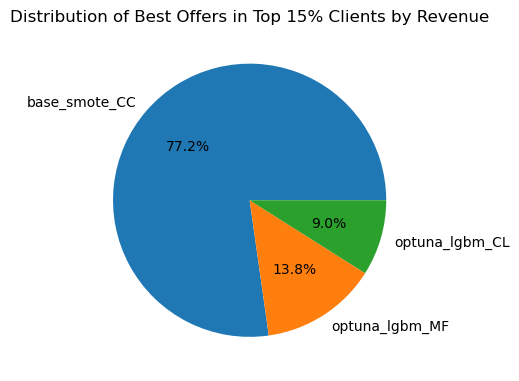

In [27]:
# Plot value counts on a pie chart
plt.figure(figsize=(5, 5))
offer_counts = top_15_pct_by_prop['best_offer'].value_counts()
plt.pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Best Offers in Top 15% Clients by Revenue')
plt.tight_layout()
plt.show()

Results from both top 15% selection methods yielded very close values ($1,359 vs $1,330). The second approach, despite yielded slightly less total revenue, has the benefit of slight diversity, allowing Mutual Funds to also get marketed without sacrificing much revenue.

### Direct Answers to Submission Questions

In [75]:
# Retrieving demographic data to answer the questions
demo_features = X_base.loc[:, ['Client', 'Sex', 'Age', 'Tenure', 'Total_ActBal', 'Credit_Debit_Ratio', 'Dormant']]

In [76]:
# Which clients have a higher propensity to buy a consumer loan?
print('Top 100 clients by propensity to buy consumer loan')
top_prop_cl = propensity_scores_selected.sort_values(by='optuna_lgbm_CL', ascending=False).iloc[:100,:].loc[:,['Client', 'optuna_lgbm_CL']].reset_index(drop=True)

top_prop_cl

Top 100 clients by propensity to buy consumer loan


,Client,optuna_lgbm_CL
0,23,0.845810
1,632,0.832452
2,350,0.829252
3,1231,0.826948
4,1561,0.814376
...,...,...
95,904,0.701497
96,1152,0.699503
97,1097,0.698891
98,1121,0.698570


In [77]:
demo_features

,Client,Sex,Age,Tenure,Total_ActBal,Credit_Debit_Ratio,Dormant
0,1,0,51,7,1333.802857,0.887227,False
1,2,1,43,152,13436.958929,1.827701,False
2,3,1,17,140,589.906429,12.882963,False
3,4,1,24,153,1889.857750,0.517869,False
4,5,0,58,200,13433.199643,0.787530,False
...,...,...,...,...,...,...,...
1610,1611,0,41,181,0.000000,0.931475,False
1611,1612,1,63,114,2368.951393,1.370480,False
1612,1613,1,46,45,676.008571,1.066829,False
1613,1614,1,48,65,0.010357,1.117768,False


In [87]:
# Get summary statistics for CL clients
summary_stats_cl = get_client_characteristics(top_prop_cl, demo_features)
summary_stats_cl

{'Average Age': 23.62,
 'Median Age': 24.0,
 'Sex Distribution': {1: 0.5, 0: 0.5},
 'Average Tenure (Months)': 183.19,
 'Median Tenure (Months)': 179.0,
 'Average Account Bal': 5158.334622857143,
 'Median Account Bal': 2071.8989285714288,
 'Average C/D ratio': 1.8463827895999636,
 'Median C/D ratio': 0.9591420838492835,
 'Dormant Distribution': {False: 1.0}}

Clients of the Consumer Loan products are typically in their early adults around 24 years old (either male or female) who have been with the bank for a very long time (approx. 12 years) which is unusual given their relatively young age. This suggests that many of these clients may have been associated with the bank from an early age, perhaps through joint accounts with parents. These clients are now entering major life stages that require financial support, such as education, early career investments, or first-time asset purchases (e.g., cars, housing deposits).

In [67]:
# Which clients have a higher propensity to buy a credit card?
print('Top 100 clients by propensity to buy credit card')
top_prop_cc = propensity_scores_selected.sort_values(by='base_smote_CC', ascending=False).iloc[:100,:].loc[:,['Client', 'base_smote_CC']].reset_index(drop=True)

top_prop_cc

Top 100 clients by propensity to buy credit card


,Client,base_smote_CC
0,1367,0.959017
1,721,0.957038
2,478,0.951485
3,1170,0.946904
4,520,0.945478
...,...,...
95,1487,0.805482
96,203,0.803286
97,618,0.802476
98,48,0.802419


In [88]:
# Get summary statistics for CL clients
summary_stats_cl = get_client_characteristics(top_prop_cl, demo_features)
summary_stats_cl

{'Average Age': 44.34,
 'Median Age': 42.0,
 'Sex Distribution': {1: 0.53, 0: 0.47},
 'Average Tenure (Months)': 104.07,
 'Median Tenure (Months)': 95.0,
 'Average Account Bal': 12119.72338607143,
 'Median Account Bal': 10632.118249999996,
 'Average C/D ratio': 0.9627428378622283,
 'Median C/D ratio': 0.9547541988746542,
 'Dormant Distribution': {False: 0.99, True: 0.01}}

Clients of the Credit Card products are typically middle-aged individuals (around 44 years old) with a fairly even gender distribution. They have been with the bank for about 8.7 years on average and maintain substantial account balances (median of ~$10.6k). Their substantial account balances (median of ~$10k) and close-to-1 credit-to-debit ratios (average of ~0.96) suggest they have strong financial management habits, likely paying off their credit card balances regularly while maintaining liquidity. These clients may be prime candidates for credit card offerings.


In [69]:
# Which clients have a higher propensity to buy a mutual fund?

print('Top 100 clients by propensity to buy mutual funds')
top_prop_mf = propensity_scores_selected.sort_values(by='optuna_lgbm_MF', ascending=False).iloc[:100,:].loc[:,['Client', 'optuna_lgbm_MF']].reset_index(drop=True)
top_prop_mf

Top 100 clients by propensity to buy mutual funds


,Client,optuna_lgbm_MF
0,390,0.897776
1,102,0.875987
2,910,0.875802
3,1149,0.870274
4,790,0.860207
...,...,...
95,806,0.684912
96,1396,0.683079
97,122,0.682993
98,109,0.682894


In [89]:
# Get summary statistics for MF clients
summary_stats_mf = get_client_characteristics(top_prop_mf, demo_features)
summary_stats_mf

{'Average Age': 42.98,
 'Median Age': 40.5,
 'Sex Distribution': {1: 0.57, 0: 0.43},
 'Average Tenure (Months)': 106.64,
 'Median Tenure (Months)': 103.0,
 'Average Account Bal': 4441.28467035714,
 'Median Account Bal': 1118.6043392857136,
 'Average C/D ratio': 72.78612988505978,
 'Median C/D ratio': 0.9844310178617752,
 'Dormant Distribution': {False: 1.0}}

Clients of the Mutual Fund products are typically middle-aged individuals (around 43 years old) with a slight male majority (57%). They have been with the bank for approximately 8.9 years and maintain moderate account balances (median of ~$1.1k). While their median credit-to-debit ratio is balanced at around 0.98, the high average ratio of 72.79 suggests majority of these clients heavily relies on credit products or engages in frequent large transactions. Their consistent account activity and relatively stable financial engagement suggest they are financially aware and actively managing their investments.


In [40]:
# Which clients are to be targeted with which offer?
top_15_pct_by_revenue

,Client,best_offer,expected_revenue
0,1367,base_smote_CC,10.417335
1,721,base_smote_CC,10.395843
2,478,base_smote_CC,10.335526
3,1170,base_smote_CC,10.285756
4,520,base_smote_CC,10.270271
...,...,...,...
140,562,optuna_lgbm_CL,8.786292
141,395,base_smote_CC,8.779584
142,1456,base_smote_CC,8.768839
143,658,base_smote_CC,8.766224


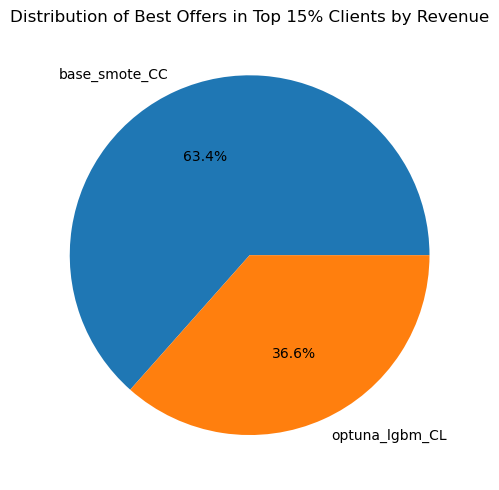

In [42]:
# Plot value counts on a pie chart
plt.figure(figsize=(5, 5))
offer_counts = top_15_pct_by_revenue['best_offer'].value_counts()
plt.pie(offer_counts.values, labels=offer_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Best Offers in Top 15% Clients by Revenue')
plt.tight_layout()
plt.show()

In [43]:
# What would be the expected revenue based on your strategy?
print(f"Total expected revenue from top 15% of clients: ${top_15_pct_by_revenue.expected_revenue.sum():,.2f}")

Total expected revenue from top 15% of clients: $1,359.83


In [44]:
## Export Results
top_prop_cl.to_csv('./output/top_prop_cl.csv')
top_prop_cc.to_csv('./output/top_prop_cc.csv')
top_prop_mf.to_csv('./output/top_prop_mf.csv')
top_15_pct_by_revenue.to_csv('./output/top_15_pct_by_revenue.csv')